In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from string import punctuation
from sklearn.feature_extraction import stop_words
stopwords = stop_words.ENGLISH_STOP_WORDS

In [128]:
len(wordcloud_stopwords)

192

In [ ]:
len(stopwords)

In [2]:
punctuation_custom = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{}~'
punctuation_custom

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{}~'

In [3]:
df_raw = pd.read_csv('../data/mbti_1.csv')

In [4]:
df_test = df_raw #[:650]  #650
df_test.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [5]:
#  Join all posts to one string for each user
df_test['posts'] = df_test['posts'].str.replace("\|\|\|", " ")
# df_test['posts'][0]

In [6]:
# group by user into condensed df
df2 = df_test.groupby('type')['posts'].apply(lambda x: "%s" % ', '.join(x)).reset_index()
# df2['type']

In [7]:
# Make a doc list of all text from the dataframe for each user type
type_list = df2['type'].tolist()
docs = df2['posts'].tolist()
# docs
# type_list

In [66]:
custom_stopwords = set("like just people don really ve http com make good things https say way going \
                        lot thing best www youtube ll pretty sure yes no actually right said thanks person \
                        watch did said does maybe probably type types doesn work life want need didn mean \
                        yeah usually got look use day long years year think know feel love friend friends \
                        thinking thought thread post personality mbti try entjs intjs enfps enfjs oh entps \
                        esfjs estjs dont espts im let time infjs infps quite makes little intps isfjs istps \
                        jpg".split())
stopwords_set = stopwords | custom_stopwords
len(custom_stopwords)

88

In [55]:
cv = CountVectorizer(docs,stop_words=stopwords_set,min_df=2)
count_vector=cv.fit_transform(docs)
count_vector.shape

(16, 50328)

In [56]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(count_vector)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [57]:
# print idf values
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"])
 
# sort ascending
df_idf.sort_values(by=['idf_weights'])

,idf_weights
sugar,1.000000
head,1.000000
using,1.000000
pictures,1.000000
evil,1.000000
...,...
lickers,2.734601
licious,2.734601
licht,2.734601
lifegoals,2.734601


In [58]:
# word counts for the docs - sparse matrix form
# count_vector=cv.transform(docs)
 
# compute tf-idf scores
tf_idf_vector=tfidf_transformer.transform(count_vector)

In [82]:
type_list.index("ESTJ")

6

In [102]:
feature_names = cv.get_feature_names()

type_id = 14
# get tfidf vector for first document
document_vector_first = tf_idf_vector[type_id]
 
# print the scores
df = pd.DataFrame(document_vector_first.T.todense(), index=feature_names, columns=[f"tfidf-{type_list[type_id]}"])
ranked_word_list = df.sort_values(by=[f"tfidf-{type_list[type_id]}"],ascending=False).reset_index()
ranked_word_list.head(20)

,index,tfidf-ISTJ
0,istj,0.422285
1,read,0.101330
2,relationship,0.092160
3,lol,0.089409
4,trying,0.088950
5,better,0.085282
6,school,0.084824
7,doing,0.083907
8,kind,0.082531
9,happy,0.082531


In [90]:
# Test code - pipeline
def merge_user_posts_into_string(df, col, delim = "\|\|\|"):
    df[col] = df[col].str.replace(delim, " ")
    return df

def group_type_posts(df, type_col, text_col):
    return df.groupby(type_col)[text_col].apply(lambda x: "%s" % ', '.join(x)).reset_index()

def create_post_length_list(dataframe, col, newcol):
    dataframe[newcol] = ""
    for i in range(len(dataframe.index)):
        char_count_list = []
        for post in range(len(dataframe[col][i])):
            char_count_list.append(len(dataframe[col][i][post]))
        dataframe[newcol][i] = char_count_list
    return dataframe

def group_post_length_lists_by_type(df, type_col, list_col):
    df2 = df.groupby(type_col).agg({list_col: 'sum'})
    return df2

In [96]:
# Test code - tf-idf
def convert_series_to_list(df, col):
    return df[col].tolist()

def create_tf_count_vectorizer(docs, stopwords, min_word_count):
    cv = CountVectorizer(docs,stop_words=stopwords,min_df=min_word_count)
    count_vector = cv.fit_transform(docs)
    # count_vector.shape
    return count_vector, cv

def compute_idf_values(word_count_vector):
    tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True)
    tfidf_transformer.fit(word_count_vector)
    return tfidf_transformer

def compute_tf_idf_scores(transformer, count_vector):
    tf_idf_vector = transformer.transform(count_vector)
    return tf_idf_vector

def create_ranked_word_list(cv, tf_idf_vector, type_id, col):
    feature_names = cv.get_feature_names()
    # get tfidf vector for first document
    document_vector = tf_idf_vector[type_id]
    # print the scores
    df = pd.DataFrame(document_vector.T.todense(), index=feature_names, columns=[col])
    ranked_word_list = df.sort_values(by=[col],ascending=False).reset_index()
    return ranked_word_list
    
def create_word_cloud_string(df, col, word_cloud_size = 200, score_scale = 1000):
    word_cloud_string = ""
    word_cloud_size = 200
    scale = 1000
    for word in range(word_cloud_size):
        num_occ = int(round(df[col][word] * scale))
        word_cloud_string += ((df['index'][word] + " ") * num_occ)
    return word_cloud_string
        
def create_word_cloud(word_cloud_string, current_type):
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                collocations=False,
                min_font_size = 10).generate(word_cloud_string) 
                    
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()
    plt.savefig(f"images/word_cloud_{current_type}.png")

In [97]:
df_raw = pd.read_csv('../data/mbti_1.csv')
current_type = "ISTJ"

In [98]:
df_user_posts_merged = merge_user_posts_into_string(df_raw, 'posts', delim = "\|\|\|")
df_type_posts_grouped = group_type_posts(df_user_posts_merged, 'type', 'posts')

type_list = convert_series_to_list(df_type_posts_grouped, 'type')
docs = convert_series_to_list(df_type_posts_grouped, 'posts')

In [99]:
# tf-idf Calculations
word_count_vector, cv = create_tf_count_vectorizer(docs, stopwords_set, min_word_count=2)
tfidf_transformer = compute_idf_values(word_count_vector)
tf_idf_vector = compute_tf_idf_scores(tfidf_transformer, word_count_vector)

In [100]:
ranked_word_list = create_ranked_word_list(cv, tf_idf_vector, 
                                           type_list.index(current_type), f"tfidf-{current_type}")

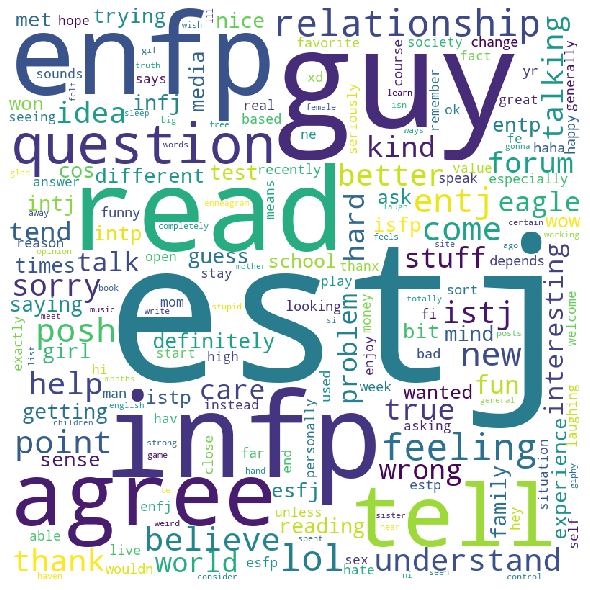

NameError: name 'fig' is not defined

In [101]:
# Word Cloud image creator
word_cloud_string = create_word_cloud_string(ranked_word_list, f"tfidf-{current_type}", word_cloud_size = 200, score_scale = 1000)
create_word_cloud(word_cloud_string, current_type)

In [76]:
word = 0
int(round(ranked_word_list[f"tfidf-{type_list[type_id]}"][word] * scale))

424

In [77]:
word_cloud_string = ""
word_cloud_size = 200
scale = 1000
for word in range(word_cloud_size):
    num_occ = int(round(ranked_word_list[f"tfidf-{type_list[type_id]}"][word] * scale))
    word_cloud_string += ((ranked_word_list['index'][word] + " ") * num_occ)
word_cloud_string

'estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj estj

In [78]:
ranked_word_list[f"tfidf-{type_list[type_id]}"]

0        0.423904
1        0.120179
2        0.115809
3        0.113624
4        0.113624
           ...   
50323    0.000000
50324    0.000000
50325    0.000000
50326    0.000000
50327    0.000000
Name: tfidf-ESTJ, Length: 50328, dtype: float64

In [79]:
ranked_word_list[f"tfidf-{type_list[type_id]}"][0]

0.42390367568984016

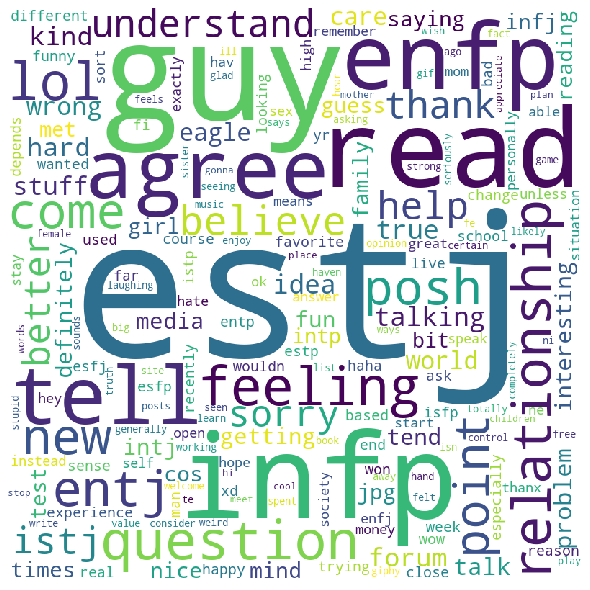

In [80]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                collocations=False,
                min_font_size = 10).generate(word_cloud_string) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [15]:
type_list

['ENFJ',
 'ENFP',
 'ENTJ',
 'ENTP',
 'ESFJ',
 'ESFP',
 'ESTJ',
 'ESTP',
 'INFJ',
 'INFP',
 'INTJ',
 'INTP',
 'ISFJ',
 'ISFP',
 'ISTJ',
 'ISTP']

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer 
 
# settings that you use for count vectorizer will go here
tfidf_vectorizer=TfidfVectorizer(use_idf=True)
 
# just send in all your docs here
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(docs)

In [23]:
# get the first vector out (for the first document)
first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[0]
 
# place tf-idf values in a pandas data frame
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)

,tfidf
to,0.398408
the,0.363429
and,0.327955
you,0.252773
of,0.225328
...,...
emersing,0.000000
emerl98,0.000000
emerging,0.000000
emerges,0.000000


In [ ]:
#instantiate CountVectorizer()
cv=CountVectorizer()
 
# this steps generates word counts for the words in your docs
word_count_vector=cv.fit_transform(docs)

In [ ]:
word_count_vector.shape

In [ ]:
cv2 = CountVectorizer(docs,stop_words=stopwords,min_df=1)
count_vector2=cv2.fit_transform(docs)
count_vector2.shape

In [ ]:
list_len =[]
for a in range(df_test.shape[0]):
    list_len.append(len(df_test['posts'][a]))
print(list_len, df_test['type'])

In [ ]:
len(df2['posts'][0])

In [ ]:
df2.head(20)

In [ ]:
df2['posts'][0] 

In [ ]:
len(docs)

In [ ]:
doc_len = []
for i in range(len(docs)):
    doc_len.append(len(docs[i]))
doc_len

In [ ]:
def to_lowercase(df, col):
    df[col] = df[col].str.lower()
    return  df
df_lw = to_lowercase(df_test, 'posts')
df_lw.head()

In [ ]:
def remove_punctuation(df, col, punctuation = punctuation):
    for post_set in range(df.shape[0]):
        df[col][post_set] = ''.join([char for char in df[col][post_set] if char not in punctuation])
    return df
df_lw_np = remove_punctuation(df_lw, 'posts', punctuation = punctuation_custom)
df_lw_np

In [ ]:
#  Strip quotes
def remove_first_last_quote(dataframe, col):
    dataframe[col] = dataframe[col].str[1:-1]
    return dataframe
df_raw_no_quote = remove_first_last_quote(df_test, 'posts')
df_raw_no_quote.head()

In [ ]:
df_raw_no_quote.posts = df_raw_no_quote.posts.str.split('\|\|\|')
df_raw_no_quote.head()

In [ ]:
# df_raw_no_quote['posts_split'] = ""

for user in range(df_raw_no_quote.shape[0]):
#     breakpoint()
    user_word_list = []
    for post_lst in range(len(df_raw_no_quote['posts'][user])):
        user_word_list += df_raw_no_quote['posts'][user][post_lst].split()
    user_word_list2 = [x for x in user_word_list if not x.startswith("http")]
    df_raw_no_quote['posts'][user] = user_word_list2
    
df_raw_no_quote.head()

In [ ]:
len(df_raw_no_quote['posts'][2])

In [ ]:
df_word_list_by_type_raw = df_raw_no_quote.groupby('type').agg({'posts': 'sum'})
df_word_list_by_type_raw.head(20)

In [ ]:
len(df_word_list_by_type_raw['posts'][11])

In [ ]:
df_word_list_by_type_raw['posts'].map(lambda x: list(map(str.lower, x)))
df_word_list_by_type_raw.head(20)

In [ ]:
type_list = df_raw['type'].head(650)
print(set(type_list))

In [ ]:
def split_df_col_text_by_delim(df, col, delim=" "):
    df[col] = df[col].str.split(delim)
    return df

In [ ]:
df_raw_no_quote.shape[0]

In [ ]:
for user in range(df_raw_no_quote.shape[0]):
    user_word_list = []
    for post in range(len(df_raw_no_quote['posts'][user])):
        len(df_raw_no_quote['posts'][user][post].str.split(" ")
        user_word_list += df_raw_no_quote['posts'][user][post]

In [ ]:
df_raw_no_quote['posts'][0]
user = 0
post_lst = 2
df_raw_no_quote['posts'][user][post_lst].split()

In [ ]:
len(df_raw_no_quote['posts_split'][0])

In [ ]:
df_raw_no_quote['posts_split'][0]

In [ ]:
fruits = {"apple", "banana", "cherry"}

fruits.discard("banana")

print(fruits)

In [ ]:
df_raw_no_quote.shape[0]

In [ ]:
import re
re.split(' |\|\|\|',str)

In [ ]:
df_raw_no_quote.posts = df_raw_no_quote.posts.str.split(' ')
df_raw_no_quote.head()

In [ ]:
# https://towardsdatascience.com/natural-language-processing-feature-engineering-using-tf-idf-e8b9d00e7e76
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform([documentA, documentB])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)

In [ ]:
# https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

In [ ]:
tfidf_transformer = TfidfTransformer()
>>> X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
>>> X_train_tfidf.shape

In [ ]:
# https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.Xo871shKiUk
